In [1]:
import sys
sys.path.insert(1, 'src')
import band_structure as bs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# definitions of all the functions that we need

# Chebyshev polynomials
def cheb(n,x):
    return np.cos(n*np.arccos(x))

# Jackson kernel
def jackson(n,N):
    phase = np.pi/(N+1)
    return ((N-n+1)*np.cos(phase*n) + np.sin(phase*n)/np.tan(phase))/(N+1)

# Chebyshev expansion of the Dirac delta
def dn(n,x):
    return 2*cheb(n,x)/np.pi/np.sqrt(1-x*x)/(1+int(n==0))

# Chebyshev expansion of the Green's function
def gn(n,z):
    return -2*1j/np.sqrt(1-z*z)*np.exp(-n*1j*np.arccos(z))/(1+int(n==0))

# Chebyshev expansion of the derivative of the Green's function
def dgn(n,z):
    sq = np.sqrt(1-z*z)
    return 2*(-1j*z + n*sq)/sq**3*np.exp(-n*1j*np.arccos(z))/(1+int(n==0))

# Fermi filling factor
def fermi(x,mu,beta):
    return 1.0/(np.exp((x - mu)*beta)+1)

def fermi0(x,mu,beta):
    return (x < mu).astype(int)

# Derivative of the Fermi factor
def dfermi(x,mu,beta):
    arg = (x - mu)*beta
    return -beta/4/np.cosh(arg/2)**2

In [3]:
GR = bs.band_structure()

# parameters of the lattice
DIM=2

a = 1
orbdic = {"A":0, "B":1}

# primitive vectors
a1 = np.array([1,  1])*a
a2 = np.array([1, 0])*a

# set the degrees of freedom inside each unit cell
# The positions are only relevant for the phase of the k-space hamiltonian
orbitals = ["A"]
# orbitals = ["A", "B"]
orb_pos = [np.array([0, 0])]

# orb_pos = [np.array([0, 0]), np.array([0.5, 0])]

t1 = 0.24
t2 = 0.1
t3 = -0.3
t4 = -0.15
t5 = 0.11
t6 = -0.09
# hops to neighbours
bonds = []
bonds.append([[ 0, 1], 'A', 'A', t1])
bonds.append([[ 1, 0], 'A', 'A', t1])
# bonds.append([[ 0, 0], 'B', 'B', t2])
# bonds.append([[ 1, 1], 'A', 'A', t3])
# bonds.append([[ 1, 0], 'B', 'A', t4])
# bonds.append([[ 1, -1], 'A', 'B', t5])
# bonds.append([[ -1, -1], 'B', 'B', t6])

m3 = bs.model()
m3.dimd = 2
m3.a1 = a1
m3.a2 = a2
m3.orbitals = orbitals
m3.orb_pos = orb_pos
m3.bonds = bonds[:]
m3.k = [0,1]


GR.set_model(m3)

In [4]:
# Now I need to define a Hamiltonian from this
# L0 = 32
# L1 = 32
# NO = GR.N_orbs
# N = L1*L0*NO



# H = np.zeros([N, N])
# for bond in GR.bonds:
#     d0, d1 = bond[0]
#     o0, o1 = orbdic[bond[1]], orbdic[bond[2]]
#     hop = bond[3]
    
#     print(d0, d1, o0, o1, hop)
#     for i0 in range(L0):
#         for i1 in range(L1):
#             i = o0*L1*L0 + i1*L0 + i0
#             j = o1*L1*L0 + ((i1 + d1)%L1)*L0 + (i0+d0)%L0
            
#             H[i,j] = hop
        


In [5]:
class ham():
    
    periodic = False
    hop = []

    def __init__(self, size0, size1, sizeO, PBC):
        self.L0 = size0
        self.L1 = size1
        self.No = sizeO
        self.N  = size0*size1*sizeO
        
        self.H  = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        self.VX = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        self.VY = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        self.X  = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        self.Y  = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        
        self.VX_eigen = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        self.VY_eigen = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        self.X_eigen  = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        self.Y_eigen  = np.matrix(np.zeros([self.N,self.N], dtype = 'complex'))
        
        self.periodic = PBC
        
    def calc_HVX(self, hoppings, dis):
        self.hop = hoppings
        #PBC = False # Periodic Boundary Conditions
        for n in range(len(hoppings)):
            h = self.hop[n]
            print(n)
    #         print(h)
            for i in range(self.L0):
                for j in range(self.L1):
                    di,dj = h[0]
                    nindex1 =  i               + self.L0*j                  + self.L0*self.L1*orbdic[h[1]]
                    nindex2 = (i + di)%self.L0 + self.L0*((j + dj)%self.L1) + self.L0*self.L1*orbdic[h[2]]

                    R1 = i*a1 + j*a2 + orb_pos[orbdic[h[1]]]
                    R2 = (i + di)*a1 + (j + dj)*a2 + orb_pos[orbdic[h[2]]]
                    dR = R1 - R2

                    if(self.periodic):
                        self.H[nindex1, nindex2] += h[3]  # PBC
                        self.VX[nindex1,nindex2] += h[3]*dR[0]*1j
                        self.VY[nindex1,nindex2] += h[3]*dR[1]*1j
                    else:
                        if(0 <= i + di <= self.L0 - 1 and 0 <= j + dj <= self.L1 - 1):
                            self.H[nindex1, nindex2] += h[3]
                            self.VX[nindex1,nindex2] += h[3]*dR[0]*1j
                            self.VY[nindex1,nindex2] += h[3]*dR[1]*1j
                    self.H[nindex1,nindex1] += dis[nindex1]

        self.vals, self.vec = np.linalg.eigh(self.H)
        self.D = np.matrix(np.diag(self.vals))
        


        #print(vals)
        print(max(self.vals), min(self.vals))
        print(min(abs(self.vals)))
    #     print(vals)
        self.VX_eigen = self.vec.H*self.VX*self.vec
        self.VY_eigen = self.vec.H*self.VY*self.vec

        # Definition of some more operators

        # X,Y position operators in position space defined explicitly


        for o in range(self.No):
            for i in range(self.L0):
                for j in range(self.L1):
                    index = i + self.L0*j + self.L0*self.L1*o
                    R = i*a1 + j*a2 + orb_pos[o]
                    self.X[index, index] = R[0]# - self.L0//2
                    self.Y[index, index] = R[1]# - self.L1//2*(a1[1] + a2[1])

        # X,Y position operators in the eigenbasis of H
        self.X_eigen = self.vec.H*self.X*self.vec
        self.Y_eigen = self.vec.H*self.Y*self.vec

        
        
    def test_code1(self):
        print("Is H hermitic?")
        print(np.linalg.norm(self.H - self.H.transpose().conjugate()))
        
        print("Are VpX,VpY hermitic?")
        print(np.linalg.norm(self.VX - self.VX.transpose().conjugate()))
        print(np.linalg.norm(self.VY - self.VY.transpose().conjugate()))
        
        

        print("Is the matrix of change of basis orthogonal?")
        print(np.linalg.norm(np.linalg.inv(self.vec) - self.vec.H))

        print("Does it diagonalize the Hamiltonian?")
        print(np.linalg.norm(self.vec.H*self.H*self.vec - self.D))
    
    def test_code2(self):
        print("Testing position and velocity operator\n")
        # Simple test to check position operators
        print("Exact values")
        av = 0
        av2 = 0
        for i in range(L0):
            for j in range(L1):
                for n in range(GR.N_orbs):
                    R = i*a1 + j*a2 + orb_pos[n]
                    av += R
                    av2 += np.array([R[0]**2, R[1]**2])

        print("X:",av[0])
        print("Y:",av[1])
        print("X*X:",av2[0])
        print("Y*Y:",av2[1])

        print("\nX operator")
        print(np.trace(self.X_eigen))
        print(np.trace(self.X))
        print(np.trace(self.X*self.X))
        print(np.trace(self.X_eigen*self.X_eigen))

        print("\nY operator")
        print(np.trace(self.Y_eigen))
        print(np.trace(self.Y))
        print(np.trace(self.Y*self.Y))
        print(np.trace(self.Y_eigen*self.Y_eigen))
        
        
        # Vx,Vy velocity operators
        Vx = 1j*(self.X*self.H - self.H*self.X)
        Vy = 1j*(self.Y*self.H - self.H*self.Y)

        # Vx,Vy position operators in the eigenbasis of H
#         Vx_eigen = vecs.H*Vx*vecs
#         Vy_eigen = vecs.H*Vy*vecs
        print("\nTesting velocity")
        print(np.linalg.norm(Vx - self.VX))
        print(np.linalg.norm(Vy - self.VY))

        # Comparison between velocity operators calculated from commutator or calculated 
# at the same time as the Hamiltonian

    def KuboBastin(self, op1, op2, mus, gamma, beta):
        
        bastin = mus*0j
        for n in range(self.N):
            en = self.vals[n]
            for m in range(self.N):
                em = self.vals[m]
                df = fermi(en, mus, beta) - fermi(em, mus, beta)
                den = (en - em + gamma*1j)**2
                bastin += op1[n,m]*op2[m,n]*df/den

        
        return -1j/self.N*bastin
    
    
    def KuboBastin0(self, op1, op2, mus, gamma, beta):
        bastin = mus*0j
        for n in range(self.N):
            en = self.vals[n]
            for m in range(self.N):
                em = self.vals[m]
                df = fermi0(en, mus, beta) - fermi0(em, mus, beta)
                den = (en - em + gamma*1j)**2
                bastin += op1[n,m]*op2[m,n]*df/den

        return -1j/self.N*bastin


    

    def KuboBastinE(self, op1, op2, mus):
        # Kubo-Bastin formula with explicit energy integration
        NE = 100
        energies = np.linspace(-2,2,NE)
        dE = energies[1] - energies[0]

        gamma = 0.1
        bastin_tr = np.zeros(NE, dtype = 'complex')

        for n in range(self.N):
            en = self.vals[n]
            gn = 1.0/(energies - en - 1j*gamma)

            for m in range(self.N):
                em = self.vals[m]
                gm = 1.0/(energies - em + 1j*gamma)**2
                bastin_tr += op1[n,m]*gm*op2[m,n]*gn.imag


        beta = 20

        bastin = np.zeros(NF, dtype = 'complex')
        dfermi_mat = np.zeros([NF, NE])

        for i in range(NE):
            e = energies[i]
            for j in range(NF):
                mu = mus[j]
                dfermi_mat[j,i] = fermi(e, mu, beta)

        bastin = -2*(np.matmul(dfermi_mat, bastin_tr)*dE/self.N).imag


        return -bastin

    
    def SingleShot(self, op1, op2, mus, gamma):
        
        bastin = mus*0j
        for n in range(self.N):
            en = self.vals[n]
            for m in range(self.N):
                em = self.vals[m]
                den1 = np.imag(1.0/(en - mus + gamma*1j))
                den2 = np.imag(1.0/(em - mus + gamma*1j))
                bastin += op1[n,m]*op2[m,n]*den1*den2

        return 1.0/self.N*bastin/np.pi
                                           
    

In [61]:
L0, L1, No = 32, 33, len(orb_pos)
b1 = ham(L0, L1, No, True)
dis = np.random.rand(L0*L1*No)/10

b1.calc_HVX(GR.bonds, dis)


0
1
2
3
1.2031146348242108 -0.7873696072128901
0.0005724038997810824


In [62]:
L0_2, L1_2, No_2 = 16, 17, len(orb_pos)

dis2 = np.random.rand(L0_2*L1_2*No_2)/10
b2 = ham(L0_2, L1_2, No_2, True)
b2.calc_HVX(GR.bonds, dis2)

0
1
2
3
1.1941768235286725 -0.7873595451119014
0.004577217183199146


In [63]:
L0_3, L1_3, No_3 = 8, 9, len(orb_pos)

dis3 = np.random.rand(L0_3*L1_3*No_3)/10
b3 = ham(L0_3, L1_3, No_3, True)
b3.calc_HVX(GR.bonds, dis3)

0
1
2
3
1.1645450095108003 -0.7857532463763822
0.019595830235589196


In [64]:
mus = np.linspace(-1,1,10000)
gamma = 0.001
gamma1 = gamma*5
gamma2 = gamma*25
beta = 1000

cond_ss1a = b1.SingleShot(b1.VX_eigen, b1.VX_eigen, mus, gamma);  print(1)
cond_ss1b = b1.SingleShot(b1.VX_eigen, b1.VX_eigen, mus, gamma1); print(1)
cond_ss1c = b1.SingleShot(b1.VX_eigen, b1.VX_eigen, mus, gamma2); print(1)

cond1a = b1.KuboBastin0(b1.VX_eigen, b1.VX_eigen, mus, gamma,  beta); print(1)
cond1b = b1.KuboBastin0(b1.VX_eigen, b1.VX_eigen, mus, gamma1, beta); print(1)
cond1c = b1.KuboBastin0(b1.VX_eigen, b1.VX_eigen, mus, gamma2, beta); print(1)


cond_ss2a = b2.SingleShot(b2.VX_eigen, b2.VX_eigen, mus, gamma);  print(1)
cond_ss2b = b2.SingleShot(b2.VX_eigen, b2.VX_eigen, mus, gamma1); print(1)
cond_ss2c = b2.SingleShot(b2.VX_eigen, b2.VX_eigen, mus, gamma2); print(1)

cond2a = b2.KuboBastin0(b2.VX_eigen, b2.VX_eigen, mus, gamma,  beta); print(1)
cond2b = b2.KuboBastin0(b2.VX_eigen, b2.VX_eigen, mus, gamma1, beta); print(1)
cond2c = b2.KuboBastin0(b2.VX_eigen, b2.VX_eigen, mus, gamma2, beta); print(1)


cond_ss3a = b3.SingleShot(b3.VX_eigen, b3.VX_eigen, mus, gamma);  print(1)
cond_ss3b = b3.SingleShot(b3.VX_eigen, b3.VX_eigen, mus, gamma1); print(1)
cond_ss3c = b3.SingleShot(b3.VX_eigen, b3.VX_eigen, mus, gamma2); print(1)

cond3a = b3.KuboBastin0(b3.VX_eigen, b3.VX_eigen, mus, gamma,  beta); print(1)
cond3b = b3.KuboBastin0(b3.VX_eigen, b3.VX_eigen, mus, gamma1, beta); print(1)
cond3c = b3.KuboBastin0(b3.VX_eigen, b3.VX_eigen, mus, gamma2, beta); print(1)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


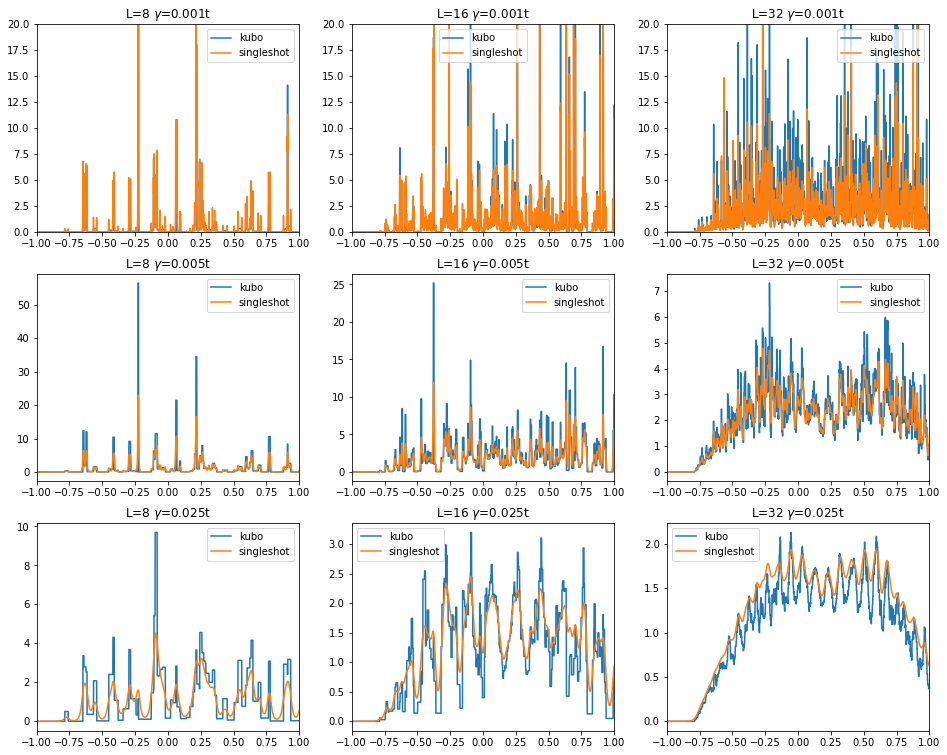

In [68]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(13)
fig.set_figwidth(16)

axs[0,0].plot(mus, np.real(cond3a),    '-', label = 'kubo')
axs[1,0].plot(mus, np.real(cond3b),    '-', label = 'kubo')
axs[2,0].plot(mus, np.real(cond3c),    '-', label = 'kubo')
axs[0,0].plot(mus, np.real(cond_ss3a), '-', label = 'singleshot')
axs[1,0].plot(mus, np.real(cond_ss3b), '-', label = 'singleshot')
axs[2,0].plot(mus, np.real(cond_ss3c), '-', label = 'singleshot')

axs[0,1].plot(mus, np.real(cond2a),    '-', label = 'kubo')
axs[1,1].plot(mus, np.real(cond2b),    '-', label = 'kubo')
axs[2,1].plot(mus, np.real(cond2c),    '-', label = 'kubo')
axs[0,1].plot(mus, np.real(cond_ss2a), '-', label = 'singleshot')
axs[1,1].plot(mus, np.real(cond_ss2b), '-', label = 'singleshot')
axs[2,1].plot(mus, np.real(cond_ss2c), '-', label = 'singleshot')

axs[0,2].plot(mus, np.real(cond1a),    '-', label = 'kubo')
axs[1,2].plot(mus, np.real(cond1b),    '-', label = 'kubo')
axs[2,2].plot(mus, np.real(cond1c),    '-', label = 'kubo')
axs[0,2].plot(mus, np.real(cond_ss1a), '-', label = 'singleshot')
axs[1,2].plot(mus, np.real(cond_ss1b), '-', label = 'singleshot')
axs[2,2].plot(mus, np.real(cond_ss1c), '-', label = 'singleshot')

Ls = [8,16,32]
gam = [0.001, 0.005, 0.025]

for i in range(3):
    for j in range(3):
        axs[i,j].set_xlim(-1,1)
        axs[i,j].set_title(r'L={0} $\gamma$={1}t'.format(Ls[j], gam[i]))
        axs[i,j].legend()
axs[0,0].set_ylim(0,20)
axs[0,1].set_ylim(0,20)
axs[0,2].set_ylim(0,20)
plt.show()

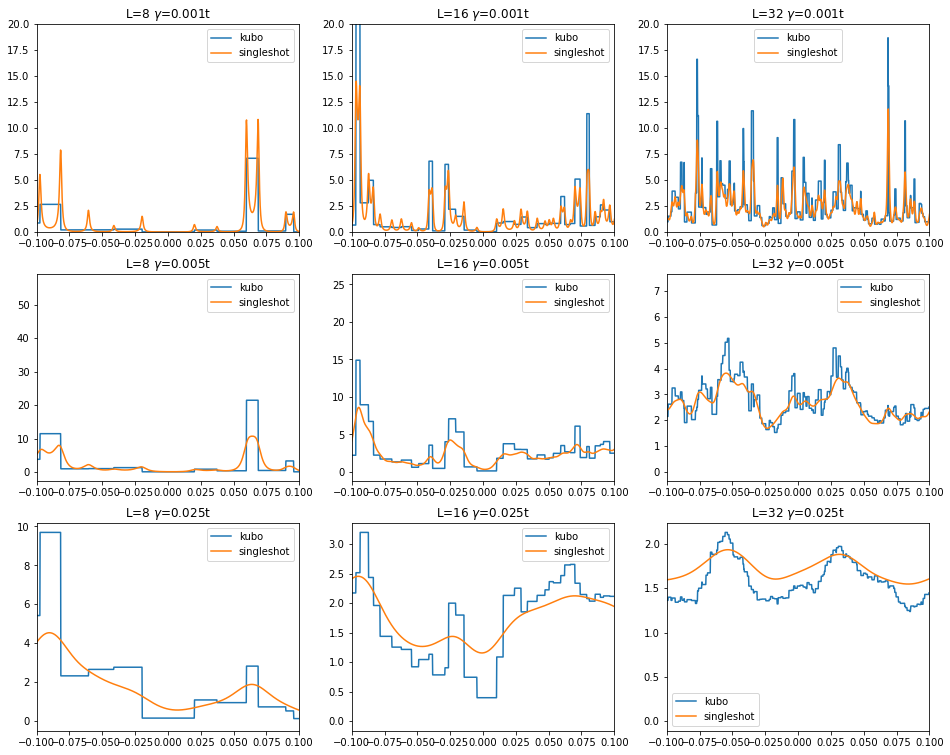

In [67]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(13)
fig.set_figwidth(16)

axs[0,0].plot(mus, np.real(cond3a),    '-', label = 'kubo')
axs[1,0].plot(mus, np.real(cond3b),    '-', label = 'kubo')
axs[2,0].plot(mus, np.real(cond3c),    '-', label = 'kubo')
axs[0,0].plot(mus, np.real(cond_ss3a), '-', label = 'singleshot')
axs[1,0].plot(mus, np.real(cond_ss3b), '-', label = 'singleshot')
axs[2,0].plot(mus, np.real(cond_ss3c), '-', label = 'singleshot')

axs[0,1].plot(mus, np.real(cond2a),    '-', label = 'kubo')
axs[1,1].plot(mus, np.real(cond2b),    '-', label = 'kubo')
axs[2,1].plot(mus, np.real(cond2c),    '-', label = 'kubo')
axs[0,1].plot(mus, np.real(cond_ss2a), '-', label = 'singleshot')
axs[1,1].plot(mus, np.real(cond_ss2b), '-', label = 'singleshot')
axs[2,1].plot(mus, np.real(cond_ss2c), '-', label = 'singleshot')

axs[0,2].plot(mus, np.real(cond1a),    '-', label = 'kubo')
axs[1,2].plot(mus, np.real(cond1b),    '-', label = 'kubo')
axs[2,2].plot(mus, np.real(cond1c),    '-', label = 'kubo')
axs[0,2].plot(mus, np.real(cond_ss1a), '-', label = 'singleshot')
axs[1,2].plot(mus, np.real(cond_ss1b), '-', label = 'singleshot')
axs[2,2].plot(mus, np.real(cond_ss1c), '-', label = 'singleshot')

Ls = [8,16,32]
gam = [0.001, 0.005, 0.025]

for i in range(3):
    for j in range(3):
        axs[i,j].set_xlim(-0.1, 0.1)
        axs[i,j].set_title(r'L={0} $\gamma$={1}t'.format(Ls[j], gam[i]))
        axs[i,j].legend()
axs[0,0].set_ylim(0,20)
axs[0,1].set_ylim(0,20)
axs[0,2].set_ylim(0,20)
plt.show()

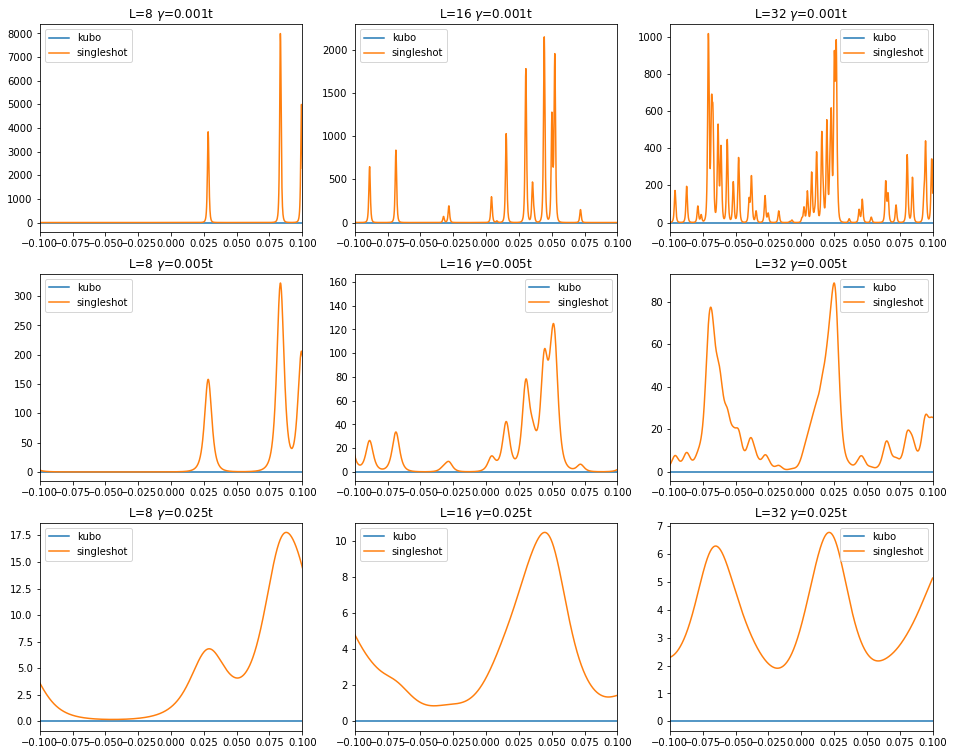

In [60]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(13)
fig.set_figwidth(16)

axs[0,0].plot(mus, np.real(cond3a),    '-', label = 'kubo')
axs[1,0].plot(mus, np.real(cond3b),    '-', label = 'kubo')
axs[2,0].plot(mus, np.real(cond3c),    '-', label = 'kubo')
axs[0,0].plot(mus, np.real(cond_ss3a), '-', label = 'singleshot')
axs[1,0].plot(mus, np.real(cond_ss3b), '-', label = 'singleshot')
axs[2,0].plot(mus, np.real(cond_ss3c), '-', label = 'singleshot')

axs[0,1].plot(mus, np.real(cond2a),    '-', label = 'kubo')
axs[1,1].plot(mus, np.real(cond2b),    '-', label = 'kubo')
axs[2,1].plot(mus, np.real(cond2c),    '-', label = 'kubo')
axs[0,1].plot(mus, np.real(cond_ss2a), '-', label = 'singleshot')
axs[1,1].plot(mus, np.real(cond_ss2b), '-', label = 'singleshot')
axs[2,1].plot(mus, np.real(cond_ss2c), '-', label = 'singleshot')

axs[0,2].plot(mus, np.real(cond1a),    '-', label = 'kubo')
axs[1,2].plot(mus, np.real(cond1b),    '-', label = 'kubo')
axs[2,2].plot(mus, np.real(cond1c),    '-', label = 'kubo')
axs[0,2].plot(mus, np.real(cond_ss1a), '-', label = 'singleshot')
axs[1,2].plot(mus, np.real(cond_ss1b), '-', label = 'singleshot')
axs[2,2].plot(mus, np.real(cond_ss1c), '-', label = 'singleshot')

Ls = [8,16,32]
gam = [0.001, 0.005, 0.025]

for i in range(3):
    for j in range(3):
        axs[i,j].set_xlim(-0.1, 0.1)
        axs[i,j].set_title(r'L={0} $\gamma$={1}t'.format(Ls[j], gam[i]))
        axs[i,j].legend()
# axs[0,1].set_ylim(0,30)
# axs[0,2].set_ylim(0,10)
plt.show()

# Density of states

$$ \rho(\varepsilon)
=\text{Tr}\left(\varepsilon-H\right)
=\sum_{n=0}^{\infty}T_n\left(\varepsilon\right)\text{Tr}\left[T_n\left(H\right)\right]
=\sum_{n=0}^{\infty}T_n\left(\varepsilon\right)\sum_{m}\left[T_n\left(\varepsilon_m\right)\right]
$$

In [ ]:
NE = 4000
NCheb = 4000
en_list = np.linspace(-0.99, 0.99,NE)
e_val = b1.vals


old_eval = e_val*0 + 1.0
new_eval = e_val*1.0

old_ens = en_list*0 + 1.0
new_ens = en_list*1.0

mu0 = old_eval.sum()
mu1 = new_eval.sum()
dos = 0.5*mu0*old_ens*jackson(0,NCheb) + mu1*new_ens*jackson(1,NCheb)

for i in range(2,NCheb):
    new_eval, old_eval = 2*e_val*new_eval  - old_eval, new_eval
    new_ens,  old_ens  = 2*en_list*new_ens - old_ens, new_ens
    moment = new_eval.sum()
    dos += moment*new_ens*jackson(i, NCheb)
    
dos = dos/np.sqrt(1-en_list**2)/b1.N/np.pi*2
print(dos.sum()*(en_list[1] - en_list[0]))

In [ ]:
plt.plot(en_list, dos)